In [ ]:
# load eval dataset
# tokenize func for eval dataset
# load all 3 models
# three models predict
# calculate all word scores for each model and each mnemonic and sort them + along with the token

In [1]:
%pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 12.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [143]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords

sw = set(stopwords.words('english'))

def tokenize(text):
    text = re.sub('<.*?>', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [w.lower() for w in tokens if w.isalpha()]
    filtered_tokens = [w.lower() for w in filtered_tokens if w.lower() not in sw]

    return filtered_tokens

In [144]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ser_model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-sensory-modality').to(device)
img_model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-imageability').to(device)
concr_model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-phrase-word-concreteness').to(device)

In [145]:
def predict(token,model):
    inputs = tokenizer(token, return_tensors='pt').to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    return logits.item()

In [146]:
keys = ['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']
def map_tokens_to_scores(example):
    for key in keys:
        tokens = tokenize(example[key])
        example[key+'_ser_scores'] = [predict(token,ser_model) for token in tokens]
        example[key+'_img_scores'] = [predict(token,img_model) for token in tokens]
        example[key+'_concr_scores'] = [predict(token,concr_model) for token in tokens]
        example[key+'_tokens'] = tokens

    return example


In [147]:
ds_scores = ds['train'].map(map_tokens_to_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [148]:
ds_scores

Dataset({
    features: ['kanji_id', 'component_meanings', 'wanikani_mnemonic', 'kanji_meaning', 'gpt2xl_mnemonic', 'gpt3_paragraph', 'gpt3_mnemonic', 'gpt2xl_mnemonic_ser_scores', 'gpt2xl_mnemonic_img_scores', 'gpt2xl_mnemonic_concr_scores', 'gpt2xl_mnemonic_tokens', 'gpt3_mnemonic_ser_scores', 'gpt3_mnemonic_img_scores', 'gpt3_mnemonic_concr_scores', 'gpt3_mnemonic_tokens', 'gpt3_paragraph_ser_scores', 'gpt3_paragraph_img_scores', 'gpt3_paragraph_concr_scores', 'gpt3_paragraph_tokens', 'wanikani_mnemonic_ser_scores', 'wanikani_mnemonic_img_scores', 'wanikani_mnemonic_concr_scores', 'wanikani_mnemonic_tokens'],
    num_rows: 190
})

In [149]:
def map_mean_scores(example):
    for key in keys:
        example[key+'_ser_mean'] = sum([score for score in example[key+'_ser_scores']])/len(example[key+'_ser_scores'])
        example[key+'_img_mean'] = sum([score for score in example[key+'_img_scores']])/len(example[key+'_img_scores'])
        example[key+'_concr_mean'] = sum([score for score in example[key+'_concr_scores']])/len(example[key+'_concr_scores'])

    return example

In [150]:
ds_mean_scores = ds_scores.map(map_mean_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [151]:
from scipy.stats import f_oneway
# features => (ser, img, concr)
def anova(ds, feature, metric):
    f, p = f_oneway(*[ds[key+'_'+feature+'_'+metric] for key in keys])
    return f, p

In [152]:
import matplotlib.pyplot as plt
import numpy as np

def box_plot(ds, feature, metric, title, labels=['GPT-2','GPT-3 (mnemonic)','GPT-3 (paragraph)','WaniKani']):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.boxplot([ds[key+'_'+feature+'_'+metric] for key in keys], labels=labels)
    plt.show()

In [153]:
from scipy.stats import tukey_hsd

def tukey(ds, feature, metric):
    data = [ds[key+'_'+feature+'_'+metric] for key in keys]
    res = tukey_hsd(*data)
    print(res)

In [154]:
print(anova(ds_mean_scores, 'ser', 'mean'))
print(anova(ds_mean_scores, 'img', 'mean'))
print(anova(ds_mean_scores, 'concr', 'mean'))

(10.941983948015764, 4.855564038581046e-07)
(8.20125113010938, 2.2388140462693895e-05)
(7.841308202404871, 3.702913648533596e-05)


In [182]:
def mean_std(ds, feature, metric):
    means = [np.mean(ds[key+'_'+feature+'_'+metric]) for key in keys]
    stds = [np.std(ds[key+'_'+feature+'_'+metric]) for key in keys]
    return means, stds

means, stds = mean_std(ds_mean_scores, 'ser', 'mean')

for i in range(len(means)):
    print(f"{keys[i]}: ${means[i]:.3f}$ & ${stds[i]:.3f}$")

gpt2xl_mnemonic: $0.337$ & $0.043$
gpt3_mnemonic: $0.320$ & $0.055$
gpt3_paragraph: $0.351$ & $0.065$
wanikani_mnemonic: $0.347$ & $0.063$


In [184]:
means, stds = mean_std(ds_mean_scores, 'img', 'mean')

for i in range(len(means)):
    print(f"{keys[i]}: ${means[i]:.3f}$ & ${stds[i]:.3f}$")
    

gpt2xl_mnemonic: $0.558$ & $0.043$
gpt3_mnemonic: $0.569$ & $0.054$
gpt3_paragraph: $0.583$ & $0.065$
wanikani_mnemonic: $0.582$ & $0.063$


In [177]:
means, stds = mean_std(ds_mean_scores, 'concr', 'mean')

for i in range(len(means)):
    print(keys[i], means[i], stds[i])

gpt2xl_mnemonic 0.5842873810109682 0.06372737315687135
gpt3_mnemonic 0.5536525571212032 0.07269158927053873
gpt3_paragraph 0.5740868576598408 0.08788197523906087
wanikani_mnemonic 0.588881082152854 0.08100371290779294


In [155]:
tukey(ds_mean_scores, 'ser', 'mean')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.017     0.018     0.002     0.032
 (0 - 2)     -0.014     0.099    -0.029     0.002
 (0 - 3)     -0.010     0.345    -0.025     0.005
 (1 - 0)     -0.017     0.018    -0.032    -0.002
 (1 - 2)     -0.031     0.000    -0.046    -0.016
 (1 - 3)     -0.027     0.000    -0.042    -0.012
 (2 - 0)      0.014     0.099    -0.002     0.029
 (2 - 1)      0.031     0.000     0.016     0.046
 (2 - 3)      0.004     0.919    -0.011     0.019
 (3 - 0)      0.010     0.345    -0.005     0.025
 (3 - 1)      0.027     0.000     0.012     0.042
 (3 - 2)     -0.004     0.919    -0.019     0.011



In [156]:
tukey(ds_mean_scores, 'img', 'mean')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.011     0.213    -0.026     0.004
 (0 - 2)     -0.025     0.000    -0.040    -0.010
 (0 - 3)     -0.024     0.000    -0.039    -0.009
 (1 - 0)      0.011     0.213    -0.004     0.026
 (1 - 2)     -0.013     0.100    -0.028     0.002
 (1 - 3)     -0.013     0.118    -0.028     0.002
 (2 - 0)      0.025     0.000     0.010     0.040
 (2 - 1)      0.013     0.100    -0.002     0.028
 (2 - 3)      0.000     1.000    -0.015     0.015
 (3 - 0)      0.024     0.000     0.009     0.039
 (3 - 1)      0.013     0.118    -0.002     0.028
 (3 - 2)     -0.000     1.000    -0.015     0.015



In [157]:
tukey(ds_mean_scores, 'concr', 'mean')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.031     0.001     0.010     0.051
 (0 - 2)      0.010     0.569    -0.010     0.031
 (0 - 3)     -0.005     0.938    -0.025     0.016
 (1 - 0)     -0.031     0.001    -0.051    -0.010
 (1 - 2)     -0.020     0.049    -0.041    -0.000
 (1 - 3)     -0.035     0.000    -0.056    -0.015
 (2 - 0)     -0.010     0.569    -0.031     0.010
 (2 - 1)      0.020     0.049     0.000     0.041
 (2 - 3)     -0.015     0.241    -0.035     0.006
 (3 - 0)      0.005     0.938    -0.016     0.025
 (3 - 1)      0.035     0.000     0.015     0.056
 (3 - 2)      0.015     0.241    -0.006     0.035



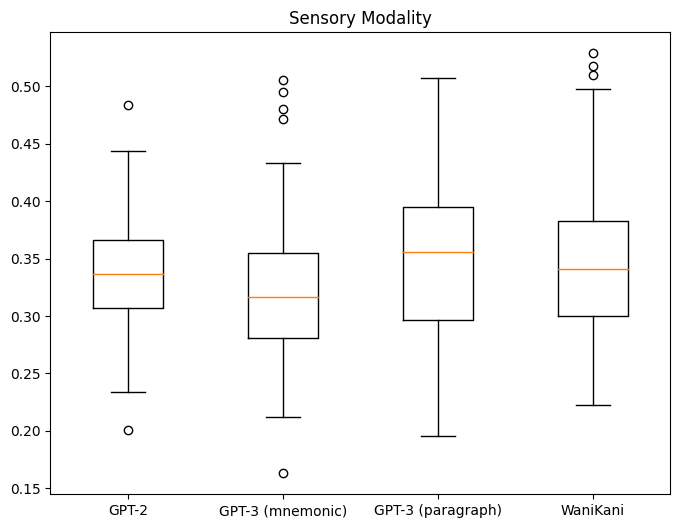

In [158]:
box_plot(ds_mean_scores, 'ser', 'mean', 'Sensory Modality')

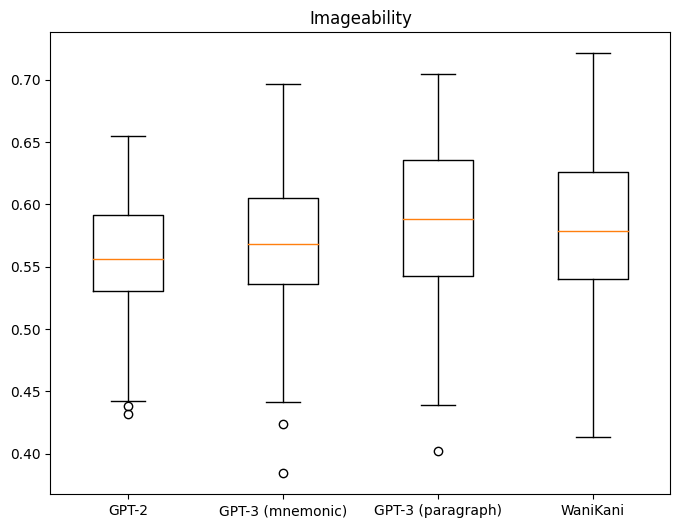

In [159]:
box_plot(ds_mean_scores, 'img', 'mean', 'Imageability')

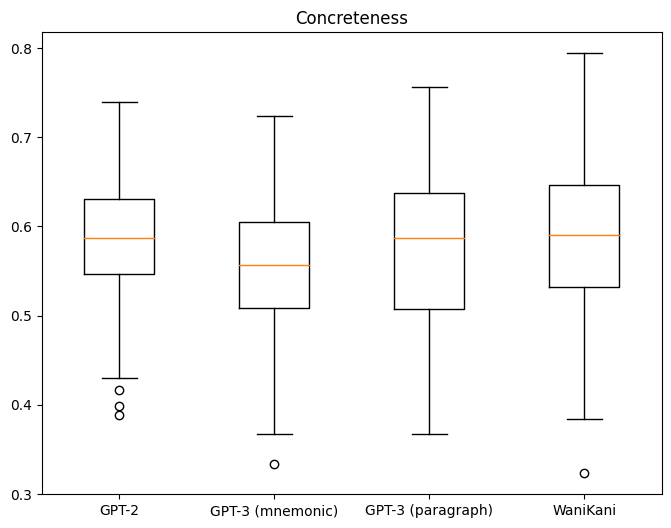

In [160]:
box_plot(ds_mean_scores, 'concr', 'mean', 'Concreteness')

In [161]:
token2scores = {}

for key in keys:
    for i in range(len(ds_scores[key+'_tokens'])):
        for j, token in enumerate(ds_scores[key+'_tokens'][i]):
            if token.lower() not in token2scores:
                token2scores[token.lower()] = {'ser': ds_scores[key+'_ser_scores'][i][j], 'img':ds_scores[key+'_img_scores'][i][j], 'concr': ds_scores[key+'_concr_scores'][i][j]}

import pandas as pd

df = pd.DataFrame.from_dict(token2scores, orient='index')

In [162]:
df.head()

,ser,img,concr
rush,0.438121,0.522701,0.509134
transcript,0.276047,0.607741,0.785303
copy,0.256791,0.655190,0.773511
may,0.292725,0.432765,0.425876
final,0.349879,0.546163,0.350708


In [163]:
def print_lowest_highest(df, feature, n=10):
    print('Lowest:')
    print(df.sort_values(feature)[:n][feature])
    print('Highest:')
    print(df.sort_values(feature, ascending=False)[:n][feature])

In [164]:
print_lowest_highest(df, 'ser')

Lowest:
yet       -0.026684
et         0.009462
since      0.011650
puts       0.012203
thus       0.014405
put        0.016692
exactly    0.020111
way        0.021824
part       0.024008
would      0.025337
Name: ser, dtype: float64
Highest:
water        0.998184
winter       0.983266
music        0.948102
river        0.940014
ocean        0.911884
rapids       0.880970
dragon       0.880138
rotten       0.879988
lightning    0.864573
tiger        0.857666
Name: ser, dtype: float64


In [165]:
print_lowest_highest(df, 'img')

Lowest:
ismaaiyl    0.094362
zeya        0.097017
fadiman     0.116099
could       0.120124
adnani      0.129697
farhad      0.131669
else        0.134640
rehm        0.135384
probably    0.140623
exactly     0.142518
Name: img, dtype: float64
Highest:
sunshine    0.985232
father      0.981055
sunset      0.980327
beach       0.978376
sun         0.976522
mother      0.974842
winter      0.974217
lake        0.974084
summer      0.972648
car         0.966286
Name: img, dtype: float64


In [166]:
print_lowest_highest(df, 'concr')

Lowest:
although    0.066866
thus        0.068167
whenever    0.076857
though      0.080742
wherever    0.093482
since       0.113371
someday     0.115476
whatever    0.116226
whose       0.117127
anyway      0.118002
Name: concr, dtype: float64
Highest:
shoe           1.024361
gun            1.023046
knife          1.022977
nails          1.018435
finger         1.017980
fingers        1.017658
nose           1.017338
sword          1.016938
fingernails    1.016718
spider         1.016492
Name: concr, dtype: float64


In [167]:
def map_median_scores(example):
    for key in keys:
        example[key+'_ser_median'] = np.median(example[key+'_ser_scores'])
        example[key+'_img_median'] = np.median(example[key+'_img_scores'])
        example[key+'_concr_median'] = np.median(example[key+'_concr_scores'])

    return example

In [168]:
ds_median_scores = ds_scores.map(map_median_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [169]:
print(anova(ds_median_scores, 'ser', 'median'))
print(anova(ds_median_scores, 'img', 'median'))
print(anova(ds_median_scores, 'concr', 'median'))

(8.954146881762611, 7.812824626592677e-06)
(6.627367579131862, 0.00020172525172357182)
(11.15433761530528, 3.609784771627332e-07)


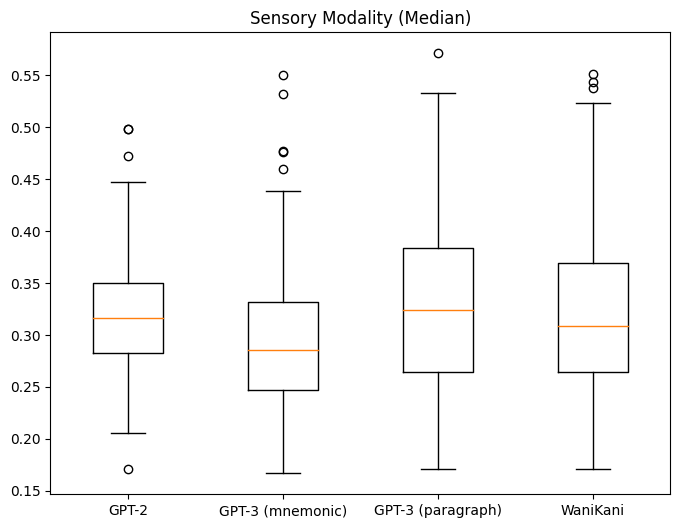

In [170]:
box_plot(ds_median_scores, 'ser', 'median', 'Sensory Modality (Median)')

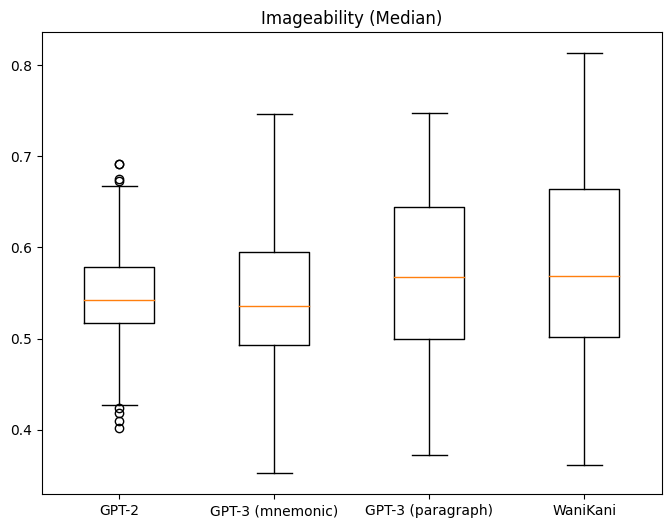

In [171]:
box_plot(ds_median_scores, 'img', 'median', 'Imageability (Median)')

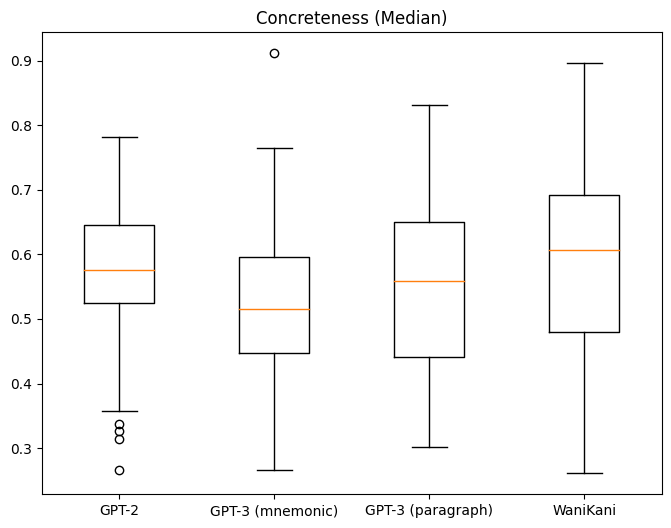

In [172]:
box_plot(ds_median_scores, 'concr', 'median', 'Concreteness (Median)')